In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import requests
import time
import gmaps

#list api keys here
from config import (api_key, gkey, sd_api_key, app_id)

state = 'Oklahoma'
state_code = 40
state_abbr = 'OK'

In [2]:
url = 'http://api.census.gov/data/2010/sf1?get=P0010001,NAME&for=county:*&in=state:40&key=' + api_key
response = requests.get(url).json()
county_name = []
county_code = []
census_variable_code = []
counter = 0;
for county in response:
    if (counter > 0):
        county_name.append(county[1])
        county_code.append(county[3])
        census_variable_code.append(county[0])
    counter = counter + 1
    
all_counties = {"County" : county_name,
               "County Code" : county_code,
               "Census Code" : census_variable_code}

all_counties_df = pd.DataFrame(all_counties)
all_counties_df.head()

,County,County Code,Census Code
0,Adair County,001,22683
1,Alfalfa County,003,5642
2,Atoka County,005,14182
3,Beaver County,007,5636
4,Beckham County,009,22119


In [3]:
url = 'http://api.census.gov/data/2010/sf1?get=P0010001,P0040003&for=zip+code+tabulation+area:*&in=state:40'
response = requests.get(url).json()
#print (response)
census_variable_p0010001 = []
census_variable_p0040003 = []
zip_code = []
counter = 0
for data in response:
    if (counter > 0):
        census_variable_p0010001.append(data[0])
        census_variable_p0040003.append(data[1])
        zip_code.append(data[3])
    counter = counter + 1

zip_codes_for_state = {"Census Code" : census_variable_p0010001,
                      "Census Code (P0040003)" : census_variable_p0040003,
                      "Zip Code" : zip_code}
zip_codes_for_state_df = pd.DataFrame(zip_codes_for_state)
zip_codes_for_state_df.head()

,Census Code,Census Code (P0040003),Zip Code
0,146,64,67950
1,1062,45,73002
2,20617,1417,73003
3,857,29,73004
4,9541,1013,73005


In [4]:
file_one = "./Resources/UnemploymentReport.csv"

income_df = pd.read_csv(file_one)
house_income = income_df[["Name", "Median Household Income (2016)"]]
house_income = house_income.dropna(how='any')


In [6]:
cities = house_income["Name"]
g_lat = []
g_lon= []
g_name = []

for city in cities:
    target_url = ('https://maps.googleapis.com/maps/api/geocode/json?address={0}&key={1}').format(city, gkey)
    geo_data = requests.get(target_url).json()
    g_name.append(city)
    g_lat.append(geo_data["results"][0]["geometry"]["location"]["lat"])
    g_lon.append(geo_data["results"][0]["geometry"]["location"]["lng"])

In [7]:
g_dict = {"Name": g_name,
          "g_lat": g_lat,
          "g_lon": g_lon}

g_df = pd.DataFrame(g_dict)

In [8]:
final_table = pd.merge(house_income, g_df, on="Name", how="left")
final_table

final_table.to_csv("./Resources/final_household_income.csv", index=False, header = True)

In [9]:
gmaps.configure(api_key=gkey)

In [10]:
locations = final_table[["g_lat", "g_lon"]].astype(float)

household_income = final_table["Median Household Income (2016)"].astype(float)

In [14]:
fig = gmaps.figure()

heat_layer = gmaps.heatmap_layer(locations, weights=household_income, 
                                 dissipating=False, max_intensity=100000,
                                 point_radius = 1)


heat_layer.dissipating = False
heat_layer.max_intensity = 100000
heat_layer.point_radius = .5

fig.add_layer(heat_layer)

fig

Figure(layout=FigureLayout(height='420px'))

In [11]:
crime_data = pd.read_csv('./Resources/crime-report.csv', encoding="utf-8")
crime_data_ok = crime_data[crime_data['state_abbr'] == 'OK']
crime_data_processed = pd.DataFrame()
crime_data_processed['Agency Name'] = crime_data_ok['agency_name']
crime_data_processed['County'] = crime_data_ok['primary_county']
crime_data_processed['FIPS'] = crime_data_ok['primary_county_fips']
clean_df = crime_data_processed.dropna()
grouped_county_crime = clean_df.groupby(['County'])
#print(grouped_county_crime.count())

In [18]:
highschool_dropout_data = pd.read_csv('./Resources/EducationReport-hd.csv', encoding="utf-8")
hs_data_processed = pd.DataFrame()
#highschool_dropout_data.head()
hs_data_processed['County'] = highschool_dropout_data['Unnamed: 1']
hs_data_processed['FIPS'] = highschool_dropout_data['Unnamed: 0']
hs_data_processed['Dropout Percentage'] = highschool_dropout_data['Unnamed: 8']

clean_hs_df = hs_data_processed.dropna()
temp_df = clean_hs_df[clean_hs_df['County'] != 'Name']
temp_df2 = temp_df[temp_df['County'] != 'Oklahoma']

county_name = []
for grade in temp_df2['County']:
    county_nm = grade.split(",")[0]
    county = county_nm.split(" ")[0]
    county_name.append(county)
    

temp_df2['County'] = county_name
temp_df2['Dropout Percentage'] = temp_df2['Dropout Percentage'].str.replace('%', '')
temp_df2.head()
#print(temp_df2)

C:\Users\SWATI KHARKAR\Anaconda3\envs\UCB-Python\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\SWATI KHARKAR\Anaconda3\envs\UCB-Python\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,County,FIPS,Dropout Percentage
3,Adair,40001,20.5
4,Alfalfa,40003,11.5
5,Atoka,40005,18.2
6,Beaver,40007,15.8
7,Beckham,40009,15.5


In [17]:
school_name = []
rating = []
low_grade = []
high_grade = []
school_level = []
county = []
district = []
year = []
#for loop that will go through school per page and add info to dictionary
for x in range(1,10):
    count = 50 #every new page the counter equals 1
    #calls the URL and gets json file
    request_url =  f"https://api.schooldigger.com/v1.1/rankings/schools/{state_abbr}?page={x}&perPage={count}&appID={app_id}&appKey={sd_api_key}"
    response = requests.get(request_url).json()
    #print(response)
    schools = response['schoolList']
    for school in schools:
        name = school['schoolName']
        school_name.append(name)
        try:
            rating.append(school['rankHistory'][0]['rank'])
            low_grade.append(school['lowGrade'])
            high_grade.append(school['highGrade'])
            school_level.append(school['schoolLevel'])
            county.append(school['county']['countyName'])
            district.append(school['district']['districtName'])
            print(f"Processed | {name}")
        except TypeError:
            print(f"Not Processed | {name}")
            
        x = x + 1 #page increases

#dictionary that will hold all data
school_dict = {"School Name": school_name,
              "Ratings": rating,
              "Low Grade": low_grade,
              "High Grade": high_grade,
              "Level": school_level,
              "County": county,
              "District": district}

#makes dictionary into DataFrame
school_df = pd.DataFrame(school_dict)
school_df.head()

Processed | Centennial Elementary School
Processed | Grove Valley Elementary School
Processed | Chisholm Elementary School
Processed | Westwood Elementary School
Processed | Cleveland Elementary School
Processed | North Intermediate School
Processed | Frontier Elementary School
Processed | Sadler Arts Academy
Processed | Prairie Vale Elementary School
Processed | Pamela Hodson Elementary School
Processed | Lakeview Elementary School
Processed | South Lake Elementary School
Processed | McKinley Elementary School
Processed | Spring Creek Elementary School
Processed | Plainview Intermediate Elementary School
Processed | McCord Public School
Processed | Heritage Elementary
Processed | Southeast Elementary School
Processed | Oakridge Elementary School
Processed | Henry Zarrow International School
Processed | Sangre Ridge Elementary School
Processed | Wilson Elementary School
Processed | Chisholm Elementary School
Processed | West Field Elementary School
Processed | Prague Elementary School


Processed | Valliant Elementary School
Processed | Collinsville Upper Elementary School
Processed | Arapaho-Butler Elementary School
Processed | Frederick Elementary School
Processed | Union Elementary School
Processed | Little Axe Elementary School
Processed | Central Elementary School
Processed | Rhoades Elementary School
Processed | Anderson Public School
Processed | Crescent Elementary School
Processed | Emerson Elementary School
Processed | Tulakes Elementary School
Processed | Apollo Elementary School
Processed | Ketchum Elementary School
Processed | Greenwood Elementary School
Processed | Mustang Trails Elementary School
Processed | Northwoods Fine Arts Academy
Processed | Mustang Creek Elementary School
Processed | Patrick Henry Elementary School
Processed | Davis Elementary School
Processed | Thomas Ies
Processed | Brantly Elementary School
Processed | Northridge Elementary School
Processed | Silo Elementary School
Processed | Lee Elementary School
Processed | Chouteau Element

,School Name,Ratings,Low Grade,High Grade,Level,County,District
0,Centennial Elementary School,1,PK,5,Elementary,Oklahoma,Edmond
1,Grove Valley Elementary School,2,PK,4,Elementary,Oklahoma,Deer Creek
2,Chisholm Elementary School,3,PK,5,Elementary,Oklahoma,Edmond
3,Westwood Elementary School,4,PK,5,Elementary,Payne,Stillwater
4,Cleveland Elementary School,5,PK,5,Elementary,Cleveland,Norman


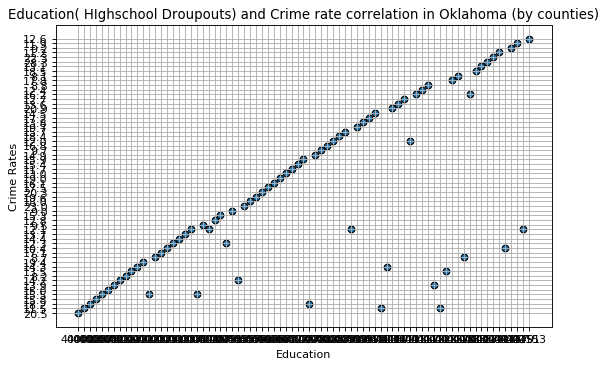

In [21]:
#Education VS Crime
plt.figure(num=None, figsize=(8,5), dpi=80)
plt.scatter(temp_df2["FIPS"],temp_df2["Dropout Percentage"],marker="o",edgecolors="black")
plt.title("Education( HIghschool Droupouts) and Crime rate correlation in Oklahoma (by counties)")
plt.ylabel("Crime Rates")
#plt.ylim(-100, 150)
plt.xlabel("Education")
#plt.xlim(-80, 100)

plt.grid(True)
plt.savefig("EducationVsCrimeRate.png")
plt.show()

In [20]:
house_income= "./Resources/final_household_income.csv"
house_income = pd.read_csv(house_income)
house_income.head()

county_name = []
for entry in house_income['Name']:
    county_nm = entry.split(",")[0]
    county = county_nm.split(" ")[0]
    county_name.append(county)

house_income['County'] = county_name    
house_income.head()

,Name,Median Household Income (2016),g_lat,g_lon,County
0,"Adair County, OK",33632.0,35.912731,-94.645035,Adair
1,"Alfalfa County, OK",53695.0,36.743592,-98.396494,Alfalfa
2,"Atoka County, OK",36766.0,34.450990,-95.983258,Atoka
3,"Beaver County, OK",53493.0,36.744019,-100.529612,Beaver
4,"Beckham County, OK",47407.0,35.268727,-99.634135,Beckham


In [24]:
inc_crime = pd.merge(house_income, crime_data_processed, how ="left", on="County")

grouped_inc= inc_crime.groupby(['County'])
#print(grouped_inc.count())

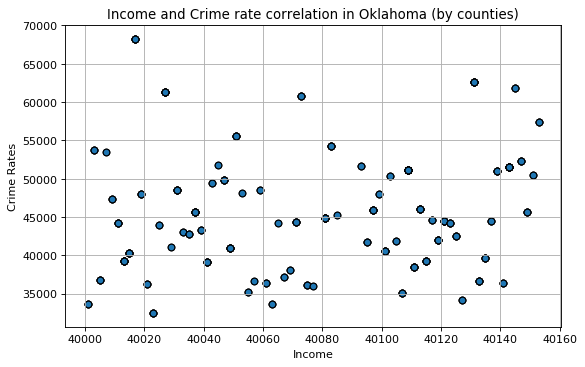

In [23]:
#Income VS Crime
plt.figure(num=None, figsize=(8,5), dpi=80)
plt.scatter(inc_crime["FIPS"],inc_crime["Median Household Income (2016)"],marker="o",edgecolors="black")
plt.title("Income and Crime rate correlation in Oklahoma (by counties)")
plt.ylabel("Income")
#plt.ylim(-100, 150)
plt.xlabel("Crime Rates")
#plt.xlim(-80, 100)

plt.grid(True)
plt.savefig("IncomeVsCrimeRate.png")
#final_table["house income"]
plt.show()